In [1]:
import math
import numpy as np
import numpy.random as npr
from numpy import linalg
import torch
import torch.nn as nn
from torch.utils import data
from torch.utils.data import Dataset
import torch.optim as optim
import time
from useful_tools import isPointinPolygon,polyshow,Genpoint,Distance_pol,GenBC
from network import ResNet
from math import *
torch.cuda.set_device(0)

In [2]:
torch.set_default_tensor_type('torch.DoubleTensor')

In [3]:
def sol_exact(x):
    N_norm_s = torch.sum(x**2,dim=1) 
    N_u = (torch.exp(N_norm_s/dim_set)).reshape([x.size()[0],1])
    return N_u
def sol_exact_H1(x):
    N_norm_s = torch.sum(x**2,dim=1)
    u = sol_exact(x)
    v= torch.ones(u.shape).cuda()
    sol = torch.zeros(x.size()[0],dim_set+1).cuda()
    sol[:,0] = u.reshape([1,x.size()[0]])
    sol[:,1:dim_set+1] = torch.autograd.grad(u,x,grad_outputs=v,create_graph=True)[0]
    return sol

In [4]:
def right(x):
    sol = torch.zeros(x.size()[0],dim_set,dim_set).cuda()
    N_norm_s = torch.sum(x**2,dim=1)
    u = sol_exact(x)
    v= torch.ones(u.shape).cuda()
    du = torch.autograd.grad(u,x,grad_outputs=v,create_graph=True)[0]
    for i in range(dim_set):
        ux_tem = du[:,i].reshape([x.size()[0],1])
        uxx_tem = torch.autograd.grad(ux_tem,x,grad_outputs=v,create_graph=True)[0]
        sol[:,:,i]= uxx_tem
    return sol

In [5]:
def generate_uniform_points_in_sphere(d,R,N):
    points = torch.randn(N,d)
    scales = (R*torch.rand(N))**(1/d)
    notes = points/(torch.sqrt(torch.sum(points**2,dim=1))/scales).reshape(N,1)*torch.ones(N ,d)
    return notes

In [6]:
dim_set = 2
Batch_size = 50000
def DGM1():
    x = generate_uniform_points_in_sphere(2,1,Batch_size).cuda()
    x.requires_grad = True
    u = model_u(x)
    du = model_p(x)
    v= torch.ones(u.shape).cuda()
    ux = torch.autograd.grad(u,x,grad_outputs=v,create_graph=True)[0]
    loss1 = torch.sum((ux-du)**2)/Batch_size
    return loss1

In [7]:
def DGM2():
    x =  generate_uniform_points_in_sphere(2,1,Batch_size).cuda()
    x.requires_grad = True
    u = model_u(x)
    v= torch.ones(u.shape).cuda()
    du = model_p(x)
    uxx = torch.zeros(Batch_size,dim_set,dim_set).cuda()
    for i in range(dim_set):
        ux_tem = du[:,i].reshape([x.size()[0],1])
        uxx_tem = torch.autograd.grad(ux_tem,x,grad_outputs=v,create_graph=True)[0]
        uxx[:,:,i] = uxx_tem
    det1 = torch.det(right(x))
    det2 = torch.det(uxx)
    loss1 = torch.sum((det1-det2)**2)/Batch_size
    return loss1

In [8]:
model_u1 = ResNet(dim_set,10,1)
model_p = ResNet(dim_set,10,dim_set)

device=torch.device("cuda:0" )
model_u1.to(device)
model_p.to(device)

ResNet(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=10, bias=True)
  (outlayer): Linear(in_features=10, out_features=2, bias=True)
)

In [9]:
def model_u(x):
    return (torch.sum(x**2,dim=1)-1).reshape([x.size()[0],1])*model_u1(x) + exp(0.5)

In [10]:
def loss_error():
    notes_error = generate_uniform_points_in_sphere(2,1,10000).cuda()
    notes_error.requires_grad= True
    exact = sol_exact_H1(notes_error)
    u_L2 = sqrt(torch.sum((exact[:,0])**2)/10000)
    Du_L2 = sqrt(torch.sum(exact[:,1:dim_set+1]**2)/10000)
    predict = torch.zeros(10000,2*dim_set+2).cuda()
    predict[:,0]= model_u(notes_error).reshape([1,notes_error.size()[0]])
    predict[:,1:dim_set+1]= model_p(notes_error)
    value1 = sqrt(torch.sum((predict[:,0] - exact[:,0])**2)/10000)/u_L2
    value2 = sqrt(torch.sum((predict[:,1:dim_set+1] - exact[:,1:dim_set+1])**2)/10000)/Du_L2
    return value1,value2

In [11]:
traintime = 10000
error_save=np.zeros([2,traintime])
optimizer = optim.Adam([
                {'params': model_u1.parameters()},
                {'params': model_p.parameters()}
            ])
i = 0
time_start=time.time()
for i in range(traintime):
    optimizer.zero_grad()
    losses = DGM1()+DGM2()
    losses.backward()
    optimizer.step() 
    error1,error2 = loss_error()
    error_save[0,i]=float(error1)
    error_save[1,i]=float(error2)
    i = i +1
    #scheduler.step()
    if i%500==1:
        print("i= ",i)
        print("error =",error1)
        print("loss1 =",losses.detach())
        np.save("error_save_LDG_MA_2D_w10.npy", error_save)
np.save("error_save_LDG_MA_2D_w10.npy", error_save)
time_end=time.time()
print('time cost',time_end-time_start,'s')

i=  1
error = 0.23570832316882745
loss1 = tensor(9.5655, device='cuda:0')
i=  501
error = 0.002350726897476174
loss1 = tensor(0.0097, device='cuda:0')
i=  1001
error = 0.0004846407285502495
loss1 = tensor(0.0024, device='cuda:0')
i=  1501
error = 0.00034239253089516194
loss1 = tensor(0.0012, device='cuda:0')
i=  2001
error = 0.00027312355583269406
loss1 = tensor(0.0007, device='cuda:0')
i=  2501
error = 0.00023309255508342872
loss1 = tensor(0.0006, device='cuda:0')
i=  3001
error = 0.00020601880674538852
loss1 = tensor(0.0005, device='cuda:0')
i=  3501
error = 0.00018082530301040165
loss1 = tensor(0.0004, device='cuda:0')
i=  4001
error = 0.00016600233785536218
loss1 = tensor(0.0003, device='cuda:0')
i=  4501
error = 0.00015782701669382588
loss1 = tensor(0.0003, device='cuda:0')
i=  5001
error = 0.00016042736677310734
loss1 = tensor(0.0003, device='cuda:0')
i=  5501
error = 0.0004221503577575265
loss1 = tensor(0.0003, device='cuda:0')
i=  6001
error = 0.00018342974481245909
loss1 = ten

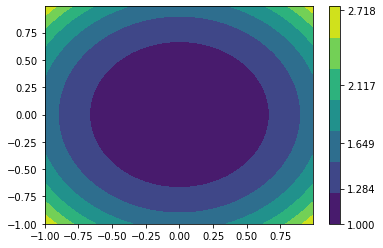

In [12]:
#导入模块
import numpy as np
import matplotlib.pyplot as plt

#建立步长为0.01，即每隔0.01取一个点
step = 0.01
x = np.arange(-1,1,step)
y = np.arange(-1,1,step)

X,Y = np.meshgrid(x,y)
an = []
for i in range(X.shape[0]):
    for j in range(Y.shape[1]):
        an.append([x[i],x[j]])
Z1 = model_u(torch.tensor(an).cuda()).reshape([X.shape[0],Y.shape[0]]).cpu().detach().numpy()
plt.contourf(X,Y,Z1)
plt.colorbar(ticks=np.exp([0, 0.25, 0.5, 0.75, 1]))

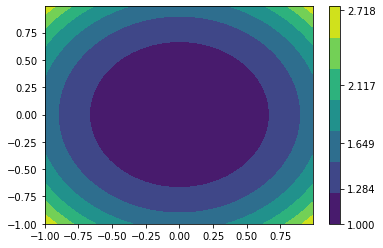

In [13]:
Z2 = sol_exact(torch.tensor(an).cuda()).reshape([X.shape[0],Y.shape[0]]).cpu().detach().numpy()
plt.contourf(X,Y,Z2)
plt.colorbar(ticks=np.exp([0, 0.25, 0.5, 0.75, 1]))

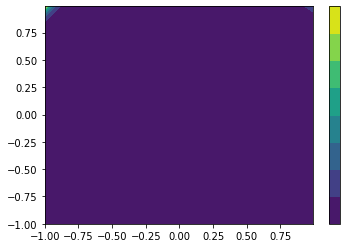

In [14]:
a = plt.contourf(X,Y,(Z1-Z2)**2)
plt.colorbar(ticks=np.exp([0, 0.25, 0.5, 0.75, 1]))

In [15]:
model_u(torch.tensor([[1.0,0.0]]).cuda())

tensor([[1.6487]], device='cuda:0', grad_fn=<AddBackward0>)

In [16]:
sol_exact(torch.tensor([[1.0,0.0]]).cuda())

tensor([[1.6487]], device='cuda:0')